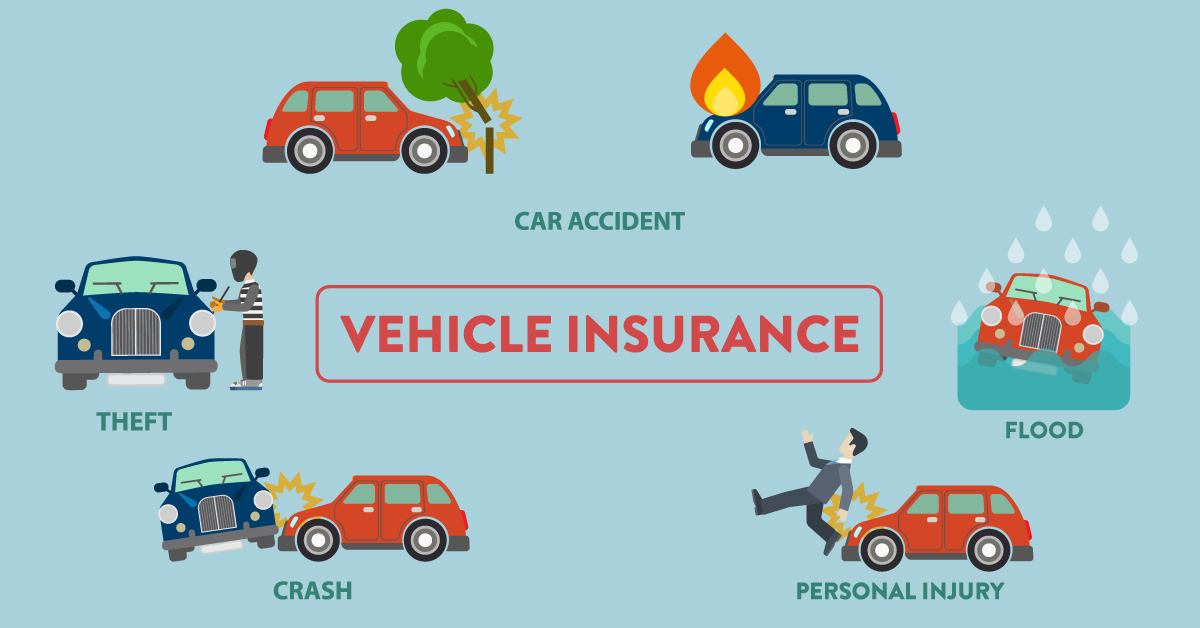

<font size="+3" color='#053c96'><b> Problem Statement</b></font>

Our client is an Insurance company that has provided Health Insurance to its customers now they need your help in building a model to predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.

An insurance policy is an arrangement by which a company undertakes to provide a guarantee of compensation for specified loss, damage, illness, or death in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

For example, you may pay a premium of Rs. 5000 each year for a health insurance cover of Rs. 200,000/- so that if, God forbid, you fall ill and need to be hospitalised in that year, the insurance provider company will bear the cost of hospitalisation etc. for upto Rs. 200,000. Now if you are wondering how can company bear such high hospitalisation cost when it charges a premium of only Rs. 5000/-, that is where the concept of probabilities comes in picture. For example, like you, there may be 100 customers who would be paying a premium of Rs. 5000 every year, but only a few of them (say 2-3) would get hospitalised that year and not everyone. This way everyone shares the risk of everyone else.

Just like medical insurance, there is vehicle insurance where every year customer needs to pay a premium of certain amount to insurance provider company so that in case of unfortunate accident by the vehicle, the insurance provider company will provide a compensation (called ‘sum assured’) to the customer.

<font size="+3" color='#053c96'><b>Bussiness Goal</b></font>

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

Now, in order to predict, whether the customer would be interested in Vehicle insurance, you have information about demographics (gender, age, region code type), Vehicles (Vehicle Age, Damage), Policy (Premium, sourcing channel) etc.

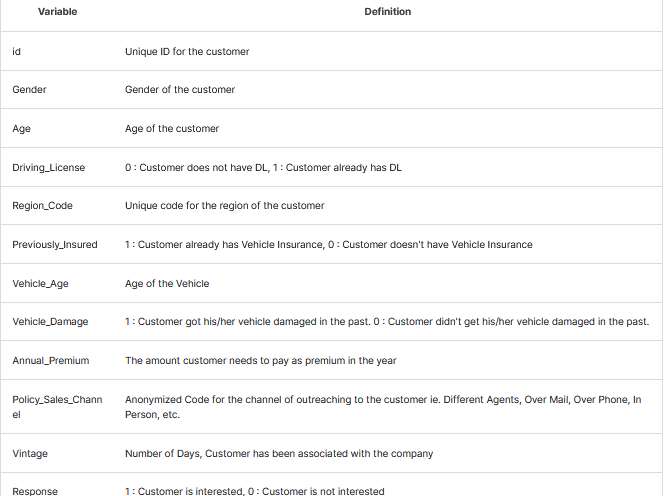

# Importing libraries, functions and loading data

## Imports

In [3]:
import pandas  as pd
import numpy   as np

import matplotlib.pyplot as plt
import seaborn           as sns

from matplotlib.ticker import FuncFormatter

import statsmodels.api as sm
from   statsmodels.stats.proportion import proportions_ztest
from   scipy.stats                  import chisquare, kstest, ttest_ind, kruskal

import scikitplot      as skplt

from sklearn                      import model_selection                as ms
from sklearn.preprocessing        import MinMaxScaler

from sklearn.tree                 import DecisionTreeClassifier
from sklearn.neighbors            import KNeighborsClassifier
from sklearn.linear_model         import LogisticRegression
from sklearn.ensemble             import RandomForestClassifier

from sklearn.metrics              import classification_report

## Define functions

In [4]:
def jupyter_settings():
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    plt.style.use('tableau-colorblind10')

In [5]:
jupyter_settings()

## Load data

In [6]:
# Carregando dados
df_test = pd.read_csv('test.csv', decimal='.', sep=',')

df_train = pd.read_csv('train.csv', decimal='.', sep=',')

# Setting data types

In [7]:
df1 = df_train.copy()

df1 = df1.astype({'Region_Code':'int64',
                  'Policy_Sales_Channel':'int64',
                  'Annual_Premium':'int64'})
df1 = df1.astype({'Region_Code':'category',
                  'Policy_Sales_Channel':'category',
                  'Vehicle_Age':'category',
                  'Previously_Insured':'category',
                  'Driving_License':'category',
                  'Gender':'category',
                  'Vehicle_Damage':'category'})

df1['Gender']               = df1['Gender'].cat.reorder_categories(['Female','Male'], ordered=True)
df1['Driving_License']      = df1['Driving_License'].cat.reorder_categories([0,1], ordered=True)
df1['Region_Code']          = df1['Region_Code'].cat.reorder_categories(np.sort(df1['Region_Code'].unique()), ordered=True)
df1['Previously_Insured']   = df1['Previously_Insured'].cat.reorder_categories([0,1], ordered=True)
df1['Vehicle_Age']          = df1['Vehicle_Age'].cat.reorder_categories(['< 1 Year', '1-2 Year', '> 2 Years'], ordered=True)
df1['Policy_Sales_Channel'] = df1['Policy_Sales_Channel'].cat.reorder_categories(np.sort(df1['Policy_Sales_Channel'].unique()), ordered=True)

# Menos que 5% do dataset de treino apresenta valores da coluna acima de 80000 e para otimizar modelo, valores nessa condicao serao reduzidos para 70000
df1['Annual_Premium']       = np.where(df1['Annual_Premium'] > 80000, 80000, df1['Annual_Premium'])

# Data Description

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## Data types

In [9]:
df1.dtypes

id                         int64
Gender                  category
Age                        int64
Driving_License         category
Region_Code             category
Previously_Insured      category
Vehicle_Age             category
Vehicle_Damage          category
Annual_Premium             int64
Policy_Sales_Channel    category
Vintage                    int64
Response                   int64
dtype: object

In [10]:
num_cols = df1.select_dtypes(include=['int64','float64']).columns
cat_cols = df1.select_dtypes(exclude=['int64','float64']).columns

## Data distribution

In [11]:
df1.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

### Numerical data

In [12]:
aux = []
for i in num_cols:
    aux.append(len(df1[i].unique()))

aux1 = df1[num_cols].describe().T
aux1['unique'] = aux

aux1

,count,mean,std,min,25%,50%,75%,max,unique
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0,381109
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,66
Annual_Premium,381109.0,30394.382995,16076.203974,2630.0,24405.0,31669.0,39400.0,80000.0,46874
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,290
Response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,2


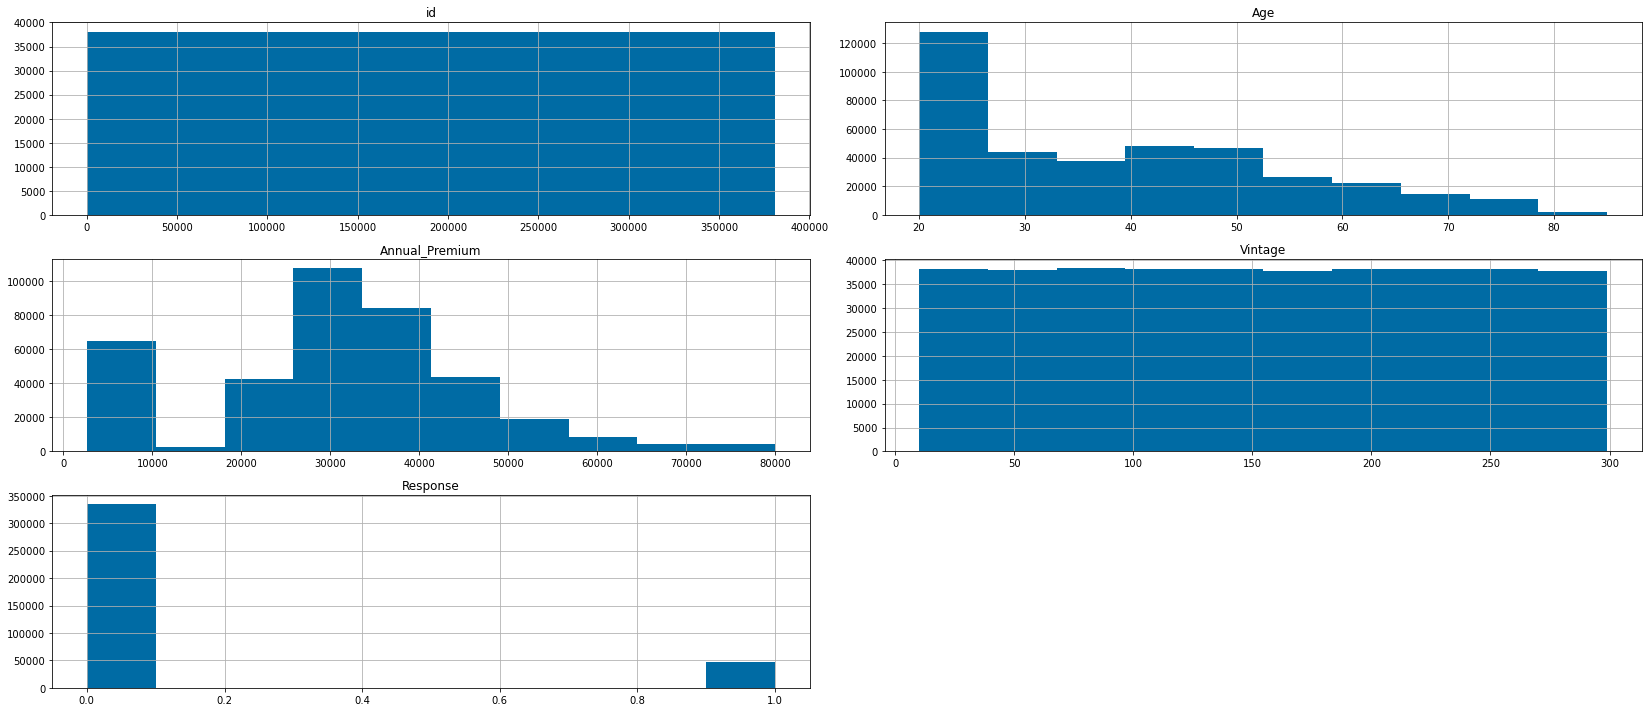

In [13]:
df1[num_cols].hist(figsize=(23,10));

plt.tight_layout()

### Categorical data

In [14]:
df1[cat_cols].describe().T

,count,unique,top,freq
Gender,381109,2,Male,206089
Driving_License,381109,2,1,380297
Region_Code,381109,53,28,106415
Previously_Insured,381109,2,0,206481
Vehicle_Age,381109,3,1-2 Year,200316
Vehicle_Damage,381109,2,Yes,192413
Policy_Sales_Channel,381109,155,152,134784


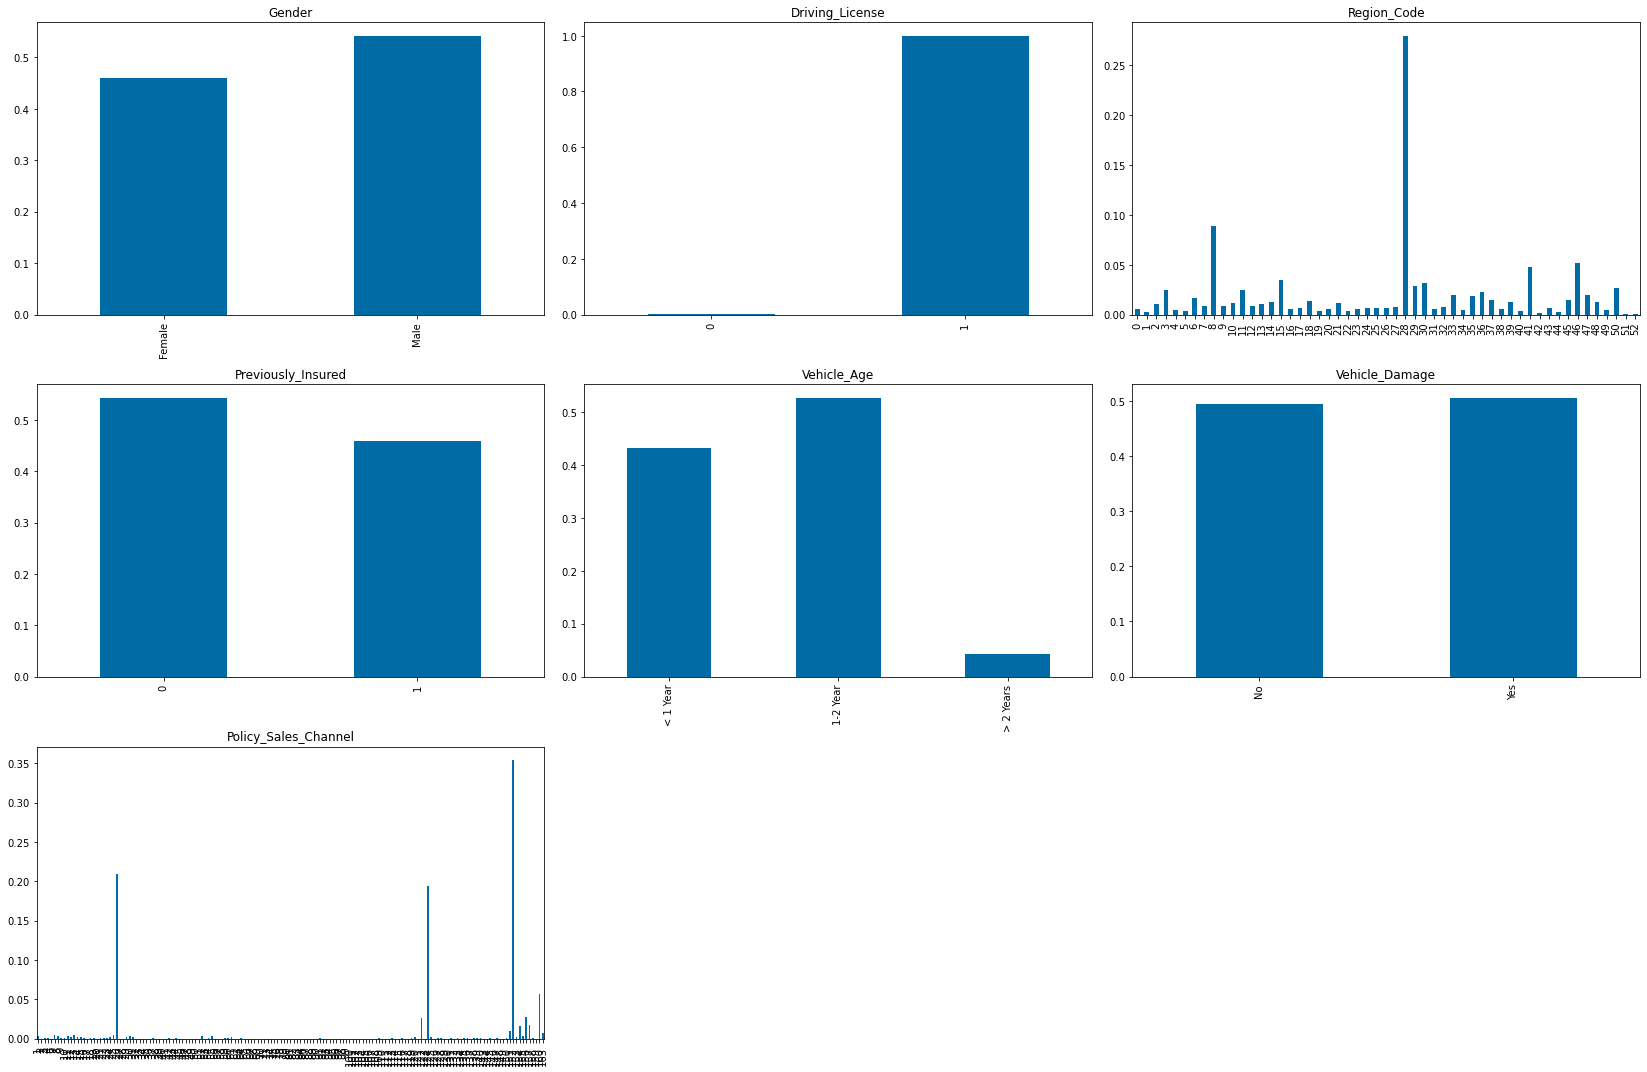

In [15]:
aux = 0
plt.figure(figsize=(23,15))
for ax in np.arange(1,8,1):
    plt.subplot(3,3,ax)
    df1[cat_cols[aux]].value_counts(normalize=True, sort=False).plot(kind='bar')
    plt.title(cat_cols[aux])
    aux += 1
    
plt.tight_layout()

# Hyperparameter tuning